In [1]:
import numpy
import pandas
from astropy import units
from galpy.util import bovy_coords, bovy_plot
import gaia_tools.load as gload
import gaia_tools.xmatch
from gaia_tools import query
import matplotlib.colors as mcolors
%pylab inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


In [24]:
def bootstrap(x,n_resamp):
    i= random.randint(0,len(x)-1,(n_resamp,len(x)))
    x_boot= x[i]
    m_boot= np.nanmedian(x_boot,axis=1)
    m= mean(m_boot)
    sigma= std(m_boot)

    return m

# The local vertical kinematics using *Gaia* DR2 and spectroscopic data sets

## Using GALAH

First we'll look at GALAH. Load the GALAH data, matched to Gaia DR2:

In [14]:
galah,gaia2_matches= gload.galah(dr=2,xmatch='gaiadr2',gaia_all_columns=True)

Compute Galactic coordinates:

In [15]:
lb_g= bovy_coords.radec_to_lb(gaia2_matches['ra'].to(units.deg).value,gaia2_matches['dec'].to(units.deg).value,degree=True)
XYZ_g= bovy_coords.lbd_to_XYZ(lb_g[:,0],lb_g[:,1],1./gaia2_matches['parallax'],degree=True)
Rxy_g= numpy.sqrt(XYZ_g[:,0]**2.+XYZ_g[:,1]**2.)
pmllbb_g= bovy_coords.pmrapmdec_to_pmllpmbb(gaia2_matches['pmra'],gaia2_matches['pmdec'],
                                         gaia2_matches['ra'],gaia2_matches['dec'],degree=True)
UVW_g= bovy_coords.vrpmllpmbb_to_vxvyvz(galah['rv_obst'],pmllbb_g[:,0],pmllbb_g[:,1],
                                      lb_g[:,0],lb_g[:,1],1./gaia2_matches['parallax'],degree=True)

Cut to good parallaxes and stars within 2 kpc from the Sun (in projection onto the plane):

In [16]:
indx_g= (gaia2_matches['parallax']/gaia2_matches['parallax_error'] > 5.)\
    *(Rxy_g < 2.)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)



The vertical (W) velocities are then (running median given as the black line)

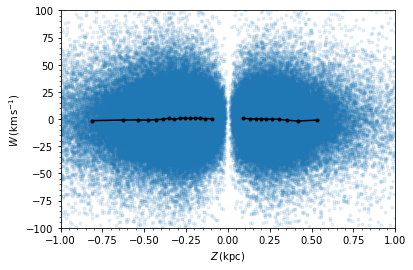

In [27]:
bovy_plot.bovy_plot(XYZ_g[indx_g,2],UVW_g[indx_g,2]-numpy.nanmedian(UVW_g[indx_g,2]),'.',alpha=0.1,
                    xrange=[-1.,1.],
                    yrange=[-100.,100.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')
sindx_g= numpy.argsort(XYZ_g[indx_g,2])
wind_g= 10000
showskip_g= wind_g
running_median_galah= pandas.DataFrame(UVW_g[indx_g,2][sindx_g]-numpy.nanmedian(UVW_g[indx_g,2]))\
        .rolling(window=wind_g,center=True,min_periods=wind_g//2)\
        .apply(func=lambda x: numpy.nanmedian(x),raw=True)
plot(XYZ_g[indx_g,2][sindx_g][::showskip_g],running_median_galah[::showskip_g],
     'k.-')

We can also estimate the uncertainty on the running median as:

In [30]:
running_median_err_galah= pandas.DataFrame(UVW_g[indx_g,2][sindx_g]-numpy.nanmedian(UVW_g[indx_g,2]))\
        .rolling(window=wind_g,center=True,min_periods=wind_g//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))),raw=True)

The running median and its error:

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)



<Container object of 3 artists>

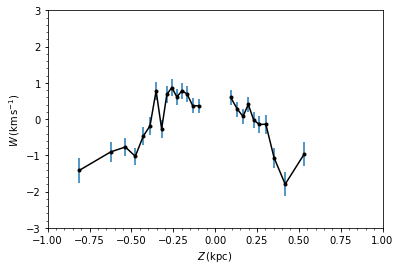

In [32]:
bovy_plot.bovy_plot(XYZ_g[indx_g,2][sindx_g][::showskip_g],running_median_galah[::showskip_g],
                    'k.-',
                    xrange=[-1.,1.],
                    yrange=[-3.,3.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')
errorbar(XYZ_g[indx_g,2][sindx_g][::showskip_g],numpy.array(running_median_galah[::showskip_g]),
         yerr=numpy.array(running_median_err_galah[::showskip_g]),
         marker='None',ls='None')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.



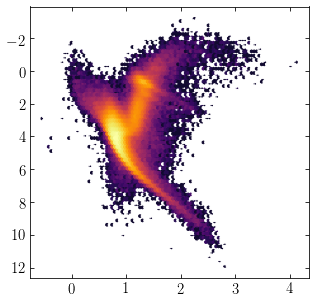

In [25]:
colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

MG= -5*log(1000/gaia2_matches['parallax'])/log(10)+5+gaia2_matches['phot_g_mean_mag']
hexbin(gaia2_matches['bp_rp'][indx_g2][sindx_g2],MG[indx_g2][sindx_g2],bins='log',cmap=cmap)

gca().invert_yaxis()

## Using APOGEE

Next, we do the same for APOGEE. Load the data:

In [35]:
apogee,apgaia2_matches= gload.apogee(xmatch='gaiadr2',gaia_all_columns=True)
apgaia2_matches= numpy.array(apgaia2_matches)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/gaia_tools-0.2-py3.6.egg/gaia_tools/load/__init__.py:73: UserWarning: Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package
  warnings.warn("Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package")



Convert coordinates:

In [36]:
lb_a= bovy_coords.radec_to_lb(apgaia2_matches['ra'],apgaia2_matches['dec'],degree=True)
XYZ_a= bovy_coords.lbd_to_XYZ(lb_a[:,0],lb_a[:,1],1./apgaia2_matches['parallax'],degree=True)
Rxy_a= numpy.sqrt(XYZ_a[:,0]**2.+XYZ_a[:,1]**2.)
pmllbb_a= bovy_coords.pmrapmdec_to_pmllpmbb(apgaia2_matches['pmra'],apgaia2_matches['pmdec'],
                                         apgaia2_matches['ra'],apgaia2_matches['dec'],degree=True)
UVW_a= bovy_coords.vrpmllpmbb_to_vxvyvz(apogee['VHELIO_AVG'],pmllbb_a[:,0],pmllbb_a[:,1],
                                      lb_a[:,0],lb_a[:,1],1./apgaia2_matches['parallax'],degree=True)

Only keep stars with good parallaxes:

In [37]:
tindx_a= (apgaia2_matches['parallax']/apgaia2_matches['parallax_error'] > 5.)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.



X vs. Z now (much closer to the plane!):

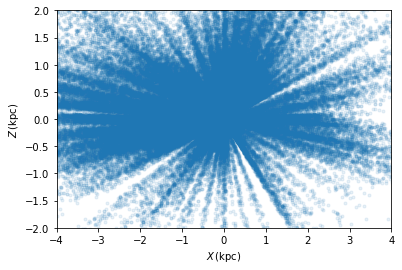

In [38]:
plot(XYZ_a[tindx_a,0],XYZ_a[tindx_a,2],'.',alpha=0.1)
xlim(-4.,4.)
ylim(-2.,2.)
xlabel(r'$X\,(\mathrm{kpc})$')
ylabel(r'$Z\,(\mathrm{kpc})$');

Only keep stars within 500 pc projected onto the plane:

In [39]:
indx_a= (apgaia2_matches['parallax']/apgaia2_matches['parallax_error'] > 5.)\
    *(Rxy_a < .5)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.



The vertical (W) velocities and their running median are:

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if __name__ == '__main__':



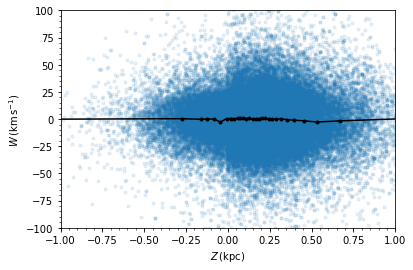

In [40]:
bovy_plot.bovy_plot(XYZ_a[indx_a,2],UVW_a[indx_a,2]-numpy.nanmedian(UVW_a[indx_a,2]),'.',alpha=0.1,
                   xrange=[-1.,1.],
                   yrange=[-100.,100.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                   
sindx_a= numpy.argsort(XYZ_a[indx_a,2])
wind_a= 3000
showskip_a= wind_a
running_median_apogee= pandas.DataFrame(UVW_a[indx_a,2][sindx_a]-numpy.nanmedian(UVW_a[indx_a,2]))\
        .rolling(window=wind_a,center=True,min_periods=wind_a//2)\
        .apply(lambda x: numpy.nanmedian(x))
plot(XYZ_a[indx_a,2][sindx_a][::showskip_a],running_median_apogee[::showskip_a],
     'k.-')

Estimate the uncertainty:

In [41]:
running_median_err_apogee= pandas.DataFrame(UVW_a[indx_a,2][sindx_a]-numpy.nanmedian(UVW_a[indx_a,2]))\
        .rolling(window=wind_a,center=True,min_periods=wind_a//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))))

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.



The median vertical velocity vs. Z:

<Container object of 3 artists>

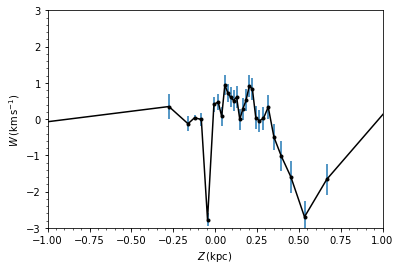

In [42]:
bovy_plot.bovy_plot(XYZ_a[indx_a,2][sindx_a][::showskip_a],running_median_apogee[::showskip_a],
                    'k.-',
                    xrange=[-1.,1.],
                    yrange=[-3.,3.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                    
errorbar(XYZ_a[indx_a,2][sindx_a][::showskip_a],numpy.array(running_median_apogee[::showskip_a]),
         yerr=numpy.array(running_median_err_apogee[::showskip_a]),
         marker='None',ls='None')

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.



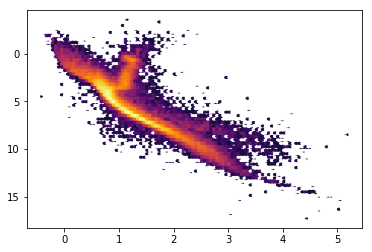

In [43]:
colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

MG= -5*log(1000/apgaia2_matches['parallax'])/log(10)+5+apgaia2_matches['phot_g_mean_mag']
hexbin(apgaia2_matches['bp_rp'][indx_a],MG[indx_a],bins='log',cmap=cmap)

gca().invert_yaxis()

# Combining all samples to get better measurements

Can combine all samples, just need to try to remove the overlap between samples (probably largest for GaiaRV/GALAH and GaiaRV/APOGEE; GALAH and APOGEE RVs are better than Gaia's). One could use any overlap to check whether the RVs between different surveys agree with each other (i.e., is mean(RV_GALAH-RV_Gaia) about 0).

## Using the *Gaia* DR2 RV sample


In [44]:
velquery= '''SELECT radial_velocity, radial_velocity_error, phot_g_mean_mag, bp_rp,
ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error
FROM gaiadr2.gaia_source
WHERE radial_velocity IS NOT Null AND parallax_over_error>5.
AND parallax IS NOT Null'''

In [45]:
out= query.query(velquery,local=False)
query.cache.nickname(velquery,'velq')

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/astropy/io/votable/tree.py:722: W35: None:5:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/astropy/io/votable/tree.py:722: W35: None:10:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/astropy/io/votable/tree.py:722: W35: None:11:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/astropy/io/votable/tree.py:722: W35: None:12:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/astropy/io/votable/tree.py:722: W35: None:14:0: W35: 'value' attribute required for INFO elements

True

In [35]:
lb= bovy_coords.radec_to_lb(array(out['ra']),array(out['dec']),degree=True)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],1./out['parallax'],degree=True)
Rxy= numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(out['pmra'],out['pmdec'],
                                         out['ra'],out['dec'],degree=True)
UVW= bovy_coords.vrpmllpmbb_to_vxvyvz(out['radial_velocity'],pmllbb[:,0],pmllbb[:,1],
                                      lb[:,0],lb[:,1],1./out['parallax'],degree=True)

In [36]:
tindx= (out['parallax']/out['parallax_error'] > 5.)

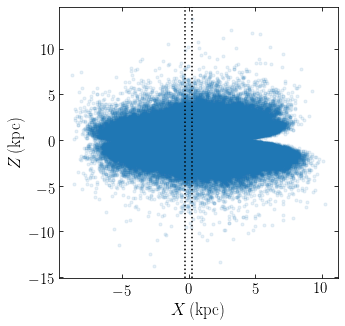

In [37]:
plot(XYZ[:,0],XYZ[:,2],'.',alpha=0.1)
xlabel(r'$X\,(\mathrm{kpc})$')
ylabel(r'$Z\,(\mathrm{kpc})$')
axvline(-0.25,color='k',ls=':')
axvline(0.25,color='k',ls=':')

In [38]:
indx= (Rxy < .25)

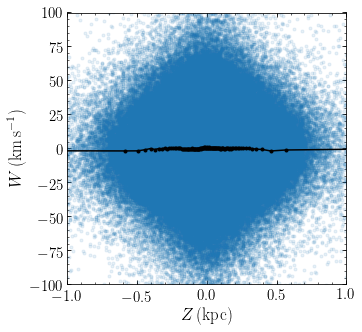

In [39]:
bovy_plot.bovy_plot(XYZ[indx,2],UVW[indx,2]-numpy.nanmedian(UVW[indx,2]),'.',alpha=0.1,
                   xrange=[-1.,1.],
                   yrange=[-100.,100.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                   
sindx= numpy.argsort(XYZ[indx,2])
wind= 8000
showskip= wind
running_median_gaia= pandas.DataFrame(UVW[indx,2][sindx]-numpy.nanmedian(UVW[indx,2]))\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: numpy.nanmedian(x),raw=True)
plot(XYZ[indx,2][sindx][::showskip],running_median_gaia[::showskip],
     'k.-')

In [40]:
running_median_err_gaia= pandas.DataFrame(UVW[indx,2][sindx]-numpy.nanmedian(UVW[indx,2]))\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.



<ErrorbarContainer object of 3 artists>

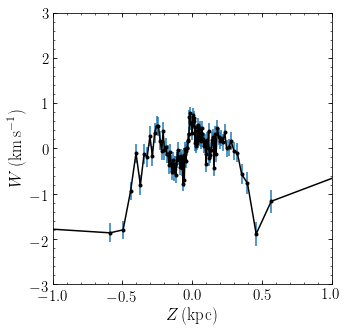

In [41]:
bovy_plot.bovy_plot(XYZ[indx,2][sindx][::showskip],running_median_gaia[::showskip],
                    'k.-',
                    xrange=[-1.,1.],
                    yrange=[-3.,3.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                    
errorbar(XYZ[indx,2][sindx][::showskip],numpy.array(running_median_gaia[::showskip]),
         yerr=numpy.array(running_median_err_gaia[::showskip]),
         marker='None',ls='None')

In [42]:
def bootstrap(x,n_resamp):
    i= random.randint(0,len(x)-1,(n_resamp,len(x)))
    x_boot= x[i]
    m_boot= np.nanmedian(x_boot,axis=1)
    m= np.nanmedian(m_boot)
    sigma= std(m_boot)
    return m,sigma

In [43]:
binw1= 0.025
binw2= 0.1
bins= append(append(numpy.round(arange(-1.5,-0.5,binw2),2),
                    numpy.round(arange(-0.5,0.5+binw1,binw1),3)),
             numpy.round(arange(0.5+binw2,1.5+binw2,binw2),2))

vave= zeros(len(bins)-1)
vave_b= zeros(len(bins)-1)
sig= zeros(len(bins)-1)
sig_b= zeros(len(bins)-1)

for i in range(len(bins)-1):
    sample= UVW[indx,2][(XYZ[indx,2]>bins[i])*(XYZ[indx,2]<bins[i+1])]-numpy.nanmedian(UVW[indx,2])
    vave[i]= median(sample)
    print(bins[i],len(sample))
    vave_b[i], sig_b[i]= bootstrap(sample,10000)
    sig[i]= 1.4826*median(abs(sample-numpy.nanmedian(sample)))/sqrt(len(sample))

-1.5 92
-1.4 129
-1.3 144
-1.2 235
-1.1 320
-1.0 470
-0.9 790
-0.8 1593
-0.7 3224
-0.6 7983
-0.5 3315
-0.475 3815
-0.45 4630
-0.425 5495
-0.4 6383
-0.375 7442
-0.35 8660
-0.325 10037
-0.3 11835
-0.275 13911
-0.25 16444
-0.225 19400
-0.2 22928
-0.175 27161
-0.15 32216
-0.125 38415
-0.1 44074
-0.075 50004
-0.05 54004
-0.025 52468
0.0 53060
0.025 53589
0.05 48635
0.075 42880
0.1 36384
0.125 30565
0.15 25892
0.175 21545
0.2 18324
0.225 15004
0.25 12347
0.275 10063
0.3 8135
0.325 6498
0.35 5308
0.375 4354
0.4 3525
0.425 2924
0.45 2518
0.475 2085
0.5 5891
0.6 3027
0.7 1392
0.8 717
0.9 422
1.0 305
1.1 195
1.2 159
1.3 98
1.4 68


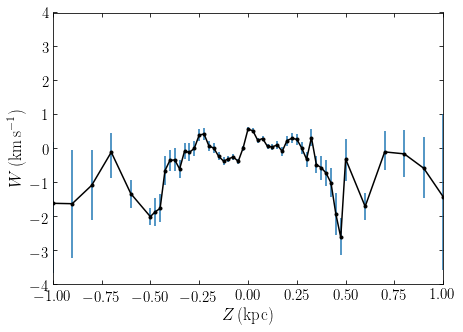

In [44]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(7,5)
plot(bins[1:],vave,'k.-')
errorbar(bins[1:],vave_b,yerr=sig_b,marker='None',ls='None')
#errorbar(bins[1:],vave,yerr=sig)
xlim([-1,1])
ylim([-4,4])

xlabel(r'$Z\,(\mathrm{kpc})$')
ylabel(r'$W\,(\mathrm{km\,s}^{-1})$')

savefig('gaia_vel.pdf',bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)

/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)



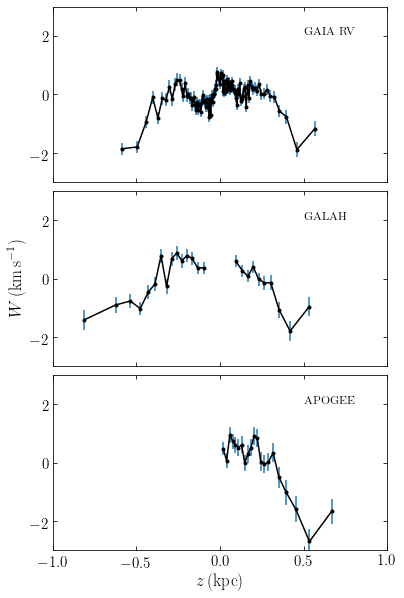

In [45]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,10)

fig, (ax1,ax2,ax3)= subplots(3,sharex=True)
fig.subplots_adjust(hspace=0.05)

ax1.text(0.5,2,r'$\mathrm{GAIA\,\,RV}$')
ax2.text(0.5,2,r'$\mathrm{GALAH}$')
ax3.text(0.5,2,r'$\mathrm{APOGEE}$')

ax2.plot(XYZ_g[indx_g2,2][sindx_g2][::showskip_g2],running_median_galah2[::showskip_g2],'k.-')
ax2.errorbar(XYZ_g[indx_g2,2][sindx_g2][::showskip_g2],numpy.array(running_median_galah2[::showskip_g2]),
         yerr=numpy.array(running_median_err_galah2[::showskip_g2]),
         marker='None',ls='None')

z_a=XYZ_a[indx_a,2][sindx_a][::showskip_a]
ax3.plot(z_a[z_a>0][:-1],running_median_apogee[::showskip_a][z_a>0][:-1],'k.-')                    
ax3.errorbar(z_a[z_a>0][:-1],numpy.array(running_median_apogee[::showskip_a][z_a>0])[:-1],
         yerr=numpy.array(running_median_err_apogee[::showskip_a][z_a>0][:-1]),
         marker='None',ls='None')

ax1.plot(XYZ[indx,2][sindx][::showskip][1:-1],running_median_gaia[::showskip][1:-1],'k.-')
ax1.errorbar(XYZ[indx,2][sindx][::showskip],numpy.array(running_median_gaia[::showskip]),
         yerr=numpy.array(running_median_err_gaia[::showskip]),
         marker='None',ls='None')
ax3.set_xlim([-1.,1.])
ax3.set_xlabel(r'$z\,(\mathrm{kpc})$')
ax2.set_ylabel(r'$W\,(\mathrm{km\,s}^{-1})$')

for a in [ax1,ax2,ax3]:
    a.set_ylim([-3.,3.])
    a.set_yticks([-2,0,2])
    
savefig('3vel.pdf',bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log



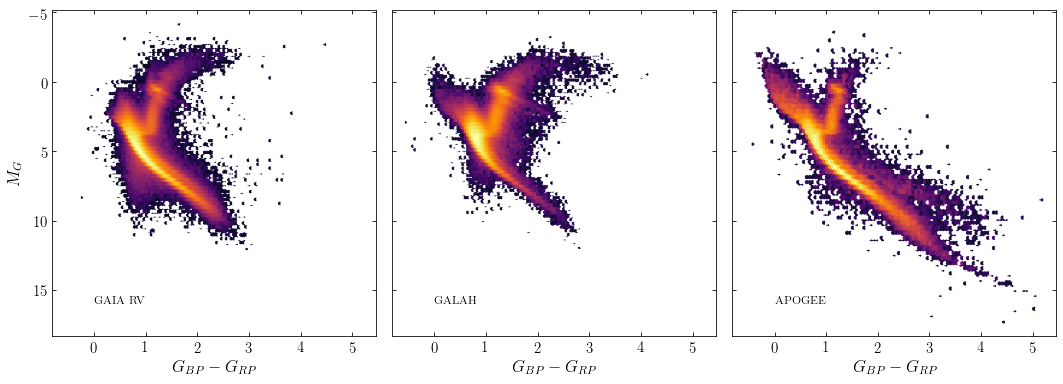

In [46]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(18,6)
colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

fig,(ax1,ax2,ax3) = subplots(1,3,sharey=True,sharex=True)
fig.subplots_adjust(wspace=0.05)

ax1.text(0,16,r'$\mathrm{GAIA\,\,RV}$')
ax2.text(0,16,r'$\mathrm{GALAH}$')
ax3.text(0,16,r'$\mathrm{APOGEE}$')

MGGG= -5*log(1000/gaia2_matches['parallax'])/log(10)+5+gaia2_matches['phot_g_mean_mag']
ax2.hexbin(gaia2_matches['bp_rp'][indx_g2],MGGG[indx_g2],bins='log',cmap=cmap)
ax2.invert_yaxis()

MGA= -5*log(1000/apgaia2_matches['parallax'])/log(10)+5+apgaia2_matches['phot_g_mean_mag']
ax3.hexbin(apgaia2_matches['bp_rp'][indx_a],MGA[indx_a],bins='log',cmap=cmap)
ax3.invert_yaxis()

MGG= -5*log(1000/out['parallax'])/log(10)+5+out['phot_g_mean_mag']
ax1.hexbin(out['bp_rp'][indx],MGG[indx],bins='log',cmap=cmap)
ax1.invert_yaxis()

ax1.set_xlabel(r'$G_{BP}-G_{RP}$')
ax2.set_xlabel(r'$G_{BP}-G_{RP}$')
ax3.set_xlabel(r'$G_{BP}-G_{RP}$')
ax1.set_ylabel(r'$M_G$')

savefig('CMD_vel.pdf',bbox_inches='tight')